# 1. Building Recommendation Systems using NETFLIX Movie Reviews
## 1.1 Context
Online movie websites like Netflix, Amazon prime uses different recommendation models to provide different suggestions to different users. Netflix currently uses item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.
## 1.2 Attribute Information
● userId : Every user identified with a unique id<br/>
● movieId: Every movie identified with a unique id<br/>
● Rating : Rating of the corresponding product by the corresponding user<br/>
● timestamp : Time of the rating ( ignore this column for this exercise)<br/>
## 1.3 Objective
Build a recommendation system to recommend products to customers based on the their previous ratings for other products.

# 2. Data Preparation and EDA
## 2.1 Loading the necessary Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

pd.plotting.register_matplotlib_converters()
%matplotlib inline
plt.style.use('seaborn-whitegrid')
pd.set_option('display.max_columns', 500)
warnings.filterwarnings("ignore")

## 2.2 Load the Dataset

In [3]:
data = pd.read_csv('ratings.csv')
data.head(5)

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [5]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
userId,100004.0,3.470113e+02,1.951638e+02,1.0,182.0,3.670000e+02,5.200000e+02,6.710000e+02
movieId,100004.0,1.254866e+04,2.636920e+04,1.0,1028.0,2.406500e+03,5.418000e+03,1.639490e+05
rating,100004.0,3.543608e+00,1.058064e+00,0.5,3.0,4.000000e+00,4.000000e+00,5.000000e+00
timestamp,100004.0,1.129639e+09,1.916858e+08,789652009.0,965847824.0,1.110422e+09,1.296192e+09,1.476641e+09


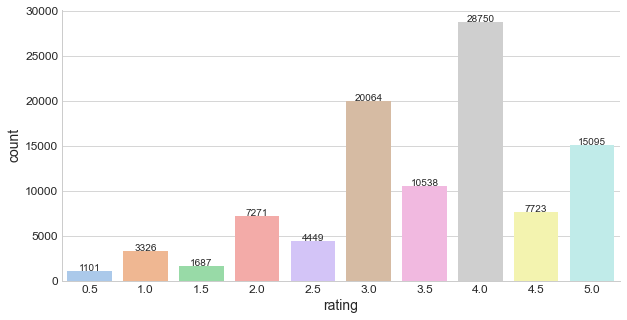

In [7]:
# Check the distribution of ratings 

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

plt.figure(figsize= (10,5))
ax = sns.countplot(x="rating", data=data, palette="pastel")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for p in ax.patches:
    ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()+8), ha='center')

plt.show()

In [61]:
# Number of unique user id and product id in the data
print('Number of unique USERS in Raw data : ', data.userId.nunique())
print('Number of unique movies in Raw data : ', data.movieId.nunique())

Number of unique USERS in Raw data :  671
Number of unique movies in Raw data :  9066


## 2.3 Take a subset of the dataset to make it less sparse/ denser. ( For example, keep the users only who has given 50 or more number of ratings )

In [11]:
# Top 10 users based on rating
most_rated = data.groupby('userId').size().sort_values(ascending=False)[:10]
most_rated

userId
547    2391
564    1868
624    1735
15     1700
73     1610
452    1340
468    1291
380    1063
311    1019
30     1011
dtype: int64

In [60]:
# Data model preparation as per requirement on number of minimum ratings = 50 for a user
counts = data['userId'].value_counts()
df_final = data[data['userId'].isin(counts[counts >= 50].index)]

print('Number of users who have rated 50 or more items =', len(df_final))
print('Number of unique USERS in final data = ', df_final['userId'].nunique())
print('Number of unique movies in final data = ', df_final['movieId'].nunique())

Number of users who have rated 50 or more items = 92421
Number of unique USERS in final data =  427
Number of unique movies in final data =  8987


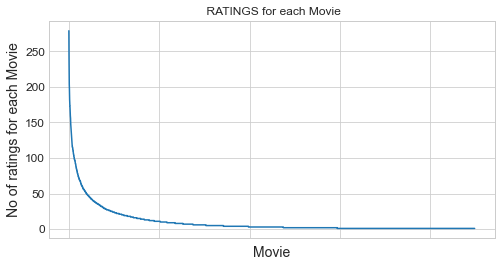

In [16]:
no_of_ratings_per_product = df_final.groupby(by='movieId')['rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_product.values)
plt.title(' RATINGS for each Movie')
plt.xlabel('Movie')
plt.ylabel('No of ratings for each Movie')
ax.set_xticklabels([])

plt.show()

In [17]:
# bdf_final has users who have rated 50 or more items.
# Calculate the density of the rating matrix

final_ratings_matrix = df_final.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0)
print(f'Shape of final ratings matrix: {final_ratings_matrix.shape}\n')

given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print(f'Given number of ratings: {given_num_of_ratings}\n')

possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print(f'Possible number of ratings: {possible_num_of_ratings}\n')

density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('Density: {:4.2f}%'.format(density))

Shape of final ratings matrix: (427, 8987)

Given number of ratings: 92421

Possible number of ratings: 3837449

Density: 2.41%


In [18]:
final_ratings_matrix.head()

movieId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,52,53,54,55,57,58,59,60,61,62,63,64,65,66,68,69,70,71,72,73,74,76,77,78,79,80,81,82,83,84,85,86,87,88,89,92,93,94,95,96,97,98,99,100,101,102,103,104,105,107,108,110,111,112,113,114,116,117,118,119,121,122,123,124,125,126,129,130,131,132,135,137,140,141,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,183,184,185,186,187,188,189,190,191,193,194,195,196,198,199,200,201,202,203,204,205,206,207,208,209,211,213,214,215,216,217,218,219,220,222,223,224,225,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,...,130452,130490,130520,130522,130576,130580,130628,130634,130642,130682,130960,130970,130980,131013,131168,131451,131714,131724,131830,132046,132074,132146,132157,132333,132462,132480,132488,132496,132618,132796,132888,132952,132961,133195,133281,133295,133365,133377,133419,133545,133645,133771,133782,133798,133824,134025,134130,134158,134170,134368,134393,134569,134853,134859,134881,135133,135137,135264,135266,135268,135436,135508,135518,135532,135536,135567,135569,135861,135887,136016,136018,136020,136305,136445,136447,136449,136562,136592,136598,136602,136654,136666,136800,136816,136864,137337,137403,137857,138036,138208,138258,138546,138696,138698,139116,139130,139385,139415,139620,139642,139644,139757,139855,139915,140110,140152,140174,140237,140247,140265,140267,140523,140711,140715,140725,140739,140741,140743,140745,140747,140749,140751,140753,140755,140757,140759,140761,140763,140816,140880,140928,141124,141422,141668,141688,141718,141749,141866,141886,141890,141956,142068,142192,142240,142258,142422,142448,142488,142507,142536,142997,143255,143257,143377,143385,143410,143472,143657,143859,144620,144714,144976,145150,145307,145775,145839,145935,146309,146443,146501,146604,146656,146682,146688,147006,147010,147037,147426,147845,148168,148238,148372,148626,148652,148881,148888,148956,149352,149354,149406,149532,149572,149590,149612,149830,150401,150548,150856,151307,151639,152017,152025,152057,152077,152079,152081,152091,152173,152844,153584,155392,155611,155820,156025,156387,156607,156609,156726,157200,157296,157407,157667,158238,158314,158528,158956,159093,159462,159690,159755,159858,159972,160080,160271,160438,160440,160563,160565,160567,160590,160656,160718,161084,161155,161594,161830,161918,161944,162376,163949
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3

In [19]:
# Matrix with one row per 'movie' and one column per 'user' for Item-based CF
final_ratings_matrix_T = final_ratings_matrix.transpose()
final_ratings_matrix_T.head()

userId,2,3,4,5,7,8,12,13,15,17,18,19,20,21,22,23,26,28,30,31,33,34,36,38,39,41,42,43,48,49,52,56,57,58,59,60,61,62,63,67,68,69,70,72,73,75,77,78,79,81,83,84,85,86,88,89,90,91,92,93,94,95,96,97,98,99,101,102,103,104,105,110,111,117,118,119,120,121,124,125,126,128,130,132,133,134,136,137,138,139,142,143,146,148,149,150,151,152,153,155,157,159,160,161,163,164,165,166,168,169,175,176,177,178,182,185,187,188,189,190,192,193,194,195,196,197,198,199,200,201,202,205,211,212,213,214,215,216,217,219,220,222,224,228,230,232,234,235,236,238,239,240,241,242,243,244,245,247,248,250,251,253,254,255,257,261,262,263,265,268,270,271,273,275,277,278,279,281,282,283,284,285,287,288,290,291,292,293,294,295,297,298,299,303,304,306,307,308,309,311,312,313,315,316,318,320,321,324,327,328,330,333,338,339,342,344,345,346,348,350,352,353,354,355,358,361,362,363,365,367,369,370,371,373,376,378,379,380,381,382,383,384,385,386,387,388,389,390,391,393,394,396,397,398,400,401,402,405,406,407,408,409,412,414,416,417,418,419,420,422,423,425,426,427,428,430,431,432,433,434,436,439,441,442,447,450,451,452,453,456,457,458,460,461,462,463,466,467,468,470,471,472,473,475,478,479,480,481,482,483,486,487,488,491,492,493,494,496,497,500,501,502,505,509,510,514,516,518,519,520,522,523,524,525,527,528,529,530,531,532,533,534,535,536,537,542,544,545,546,547,548,550,551,553,554,555,557,558,559,560,561,562,563,564,569,570,571,572,574,575,577,580,582,584,585,586,587,588,590,592,593,594,595,596,597,598,599,602,603,605,606,607,608,609,610,612,613,614,615,617,620,621,623,624,625,626,627,628,639,641,646,647,648,649,652,653,654,655,656,658,659,660,662,664,665,667,671
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,3.0,0.0,0.0,5.0,2.0,0.0,0.0,3.0,3.5,0.0,0.0,3.0,5.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,3.0,4.0,5.0,5.0,3.5,5.0,3.0,4.0,0.0,2.0,0.0,0.0,3.5,0.0,3.0,0.0,5.0,4.0,5.0,5.0,4.0,4.0,0.0,0.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.5,4.0,4.5,4.0,5.0,5.0,3.0,0.0,0.0,3.5,4.5,0.0,2.0,0.0,4.0,0.0,5.0,0.0,3.0,3.0,0.0,3.5,5.0,0.0,3.5,0.0,0.0,0.0,3.0,3.5,2.5,0.0,5.0,4.0,4.0,2.0,5.0,4.0,0.0,5.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,5.0,0.0,4.5,0.0,3.0,3.0,0.0,3.0,0.0,0.0,5.0,2.0,0.0,4.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,4.5,3.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,1.5,2.5,0.0,0.0,5.0,0.0,0.0,4.5,5.0,0.0,0.0,0.0,0.0,4.0,3.0,3.0,4.0,5.0,0.0,0.0,0.0,4.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,3.0,5.0,4.0,0.0,0.0,1.0,0.0,3.0,4.0,0.0,4.0,0.0,4.0,0.0,0.0,0.0,4.0,4.5,0.0,0.0,4.0,0.0,3.5,5.0,3.0,5.0,3.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,4.0,0.0,3.5,5.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,2.0,0.0,3.5,4.0,2.0,5.0,4.0,0.0,0.0,3.5,3.5,4.5,0.0,5.0,0.0,4.5,3.0,0.0,5.0,4.0,4.5,5.0,4.5,4.0,0.0,0.0,0.0,4.0,3.0,0.0,0.0,3.5,0.0,3.5,1.5,3.5,4.5,3.5,0.0,3.0,5.0,0.0,4.0,3.5,3.5,5.0,0.0,4.5,0.0,0.0,5.0,4.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,2.0,5.0,4.0,0.0,3.0,1.0,4.0,0.0,5.0,0.0,3.0,0.0,0.0,0.0,2.0,0.0,0.0,4.0,5.0,3.0,0.0,0.0,5.0,0.0,0.0,5.0,4.5,0.0,0.0,0.0,3.5,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,4.5,3.0,4.5,0.0,4.0,0.0,1.5,0.0,0.0,4.0,3.0,5.0,4.0,0.0,5.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,5.0,3.5,5.0,4.5,0.0,0.0,4.0,0.0,0.0,4.5,4.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,4.5,5.0,0.0,0.0,0.0,0.0,0.0,4.0,5.0,4.0,0.0,4.0,0.0,4.0,5.0,0.0,0.0,0.0,0.0,2.5,0.0,3.5,0.0,0.0,5.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,3.5,5.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,3.0,3.5,0.0,2.5,2.5,0.0,0.0,3.5,2.5,0.0,0.0,0.0,5.

In [20]:
# We will exclude the timestamp column from analysis
df_final.drop(['timestamp'], axis=1,inplace=True)
df_final.head()

,userId,movieId,rating
20,2,10,4.0
21,2,17,5.0
22,2,39,5.0
23,2,47,4.0
24,2,50,4.0


# 3. Building Recommendation Systems
## 3.1 Train - Test Split

In [21]:
# Split the data randomly into train and test dataset. ( For example, split it in 70/30 ratio).
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df_final, test_size = 0.3, random_state=0)
train_data.head()

,userId,movieId,rating
62607,452,6461,4.0
96782,648,1263,2.0
29140,212,44022,2.5
87781,584,63082,5.0
71476,501,6016,5.0


In [22]:
print(f'Shape of train dataset: {train_data.shape}')
print(f'Shape of test dataset: {test_data.shape}')

Shape of train dataset: (64694, 3)
Shape of test dataset: (27727, 3)


## 3.2 Popularity based Recommendation system

In [23]:
#Count of user id for each unique product as recommendation score 
train_data_grouped = train_data.groupby('movieId').agg({'userId': 'count'}).reset_index()
train_data_grouped.rename(columns = {'userId': 'score'},inplace=True)
train_data_grouped.head()

,movieId,score
0,1,142
1,2,68
2,3,24
3,4,6
4,5,34


In [24]:
#Sort the products on recommendation score 
train_data_sort = train_data_grouped.sort_values(['score', 'movieId'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score 
train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations

,movieId,score,Rank
310,356,191,1.0
257,296,181,2.0
275,318,170,3.0
507,593,163,4.0
1960,2571,162,5.0


In [25]:
# Use popularity based recommender model to make predictions
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['userID'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations 

In [26]:
find_recom = ['3','296','5']   # This list is user choice.
for i in find_recom:
    print(f"Here is the recommendation for the userId: {i}\n")
    print(recommend(i))    
    print("\n")

Here is the recommendation for the userId: 3

     userID  movieId  score  Rank
310       3      356    191   1.0
257       3      296    181   2.0
275       3      318    170   3.0
507       3      593    163   4.0
1960      3     2571    162   5.0


Here is the recommendation for the userId: 296

     userID  movieId  score  Rank
310     296      356    191   1.0
257     296      296    181   2.0
275     296      318    170   3.0
507     296      593    163   4.0
1960    296     2571    162   5.0


Here is the recommendation for the userId: 5

     userID  movieId  score  Rank
310       5      356    191   1.0
257       5      296    181   2.0
275       5      318    170   3.0
507       5      593    163   4.0
1960      5     2571    162   5.0




Since this is a popularity-based recommender model, recommendations remain the same for all users. We predict the products based on the popularity. It is not personalized to particular user.

## 3.3 Building Collaborative Filtering model
Model-based Collaborative Filtering: Singular Value Decomposition

In [27]:
df_CF = pd.concat([train_data, test_data]).reset_index()
df_CF.head()

,index,userId,movieId,rating
0,62607,452,6461,4.0
1,96782,648,1263,2.0
2,29140,212,44022,2.5
3,87781,584,63082,5.0
4,71476,501,6016,5.0


In [28]:
#User-based Collaborative Filtering
# Matrix with row per 'user' and column per 'item' 
pivot_df = df_CF.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0)
pivot_df.shape
pivot_df.head()

movieId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,52,53,54,55,57,58,59,60,61,62,63,64,65,66,68,69,70,71,72,73,74,76,77,78,79,80,81,82,83,84,85,86,87,88,89,92,93,94,95,96,97,98,99,100,101,102,103,104,105,107,108,110,111,112,113,114,116,117,118,119,121,122,123,124,125,126,129,130,131,132,135,137,140,141,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,183,184,185,186,187,188,189,190,191,193,194,195,196,198,199,200,201,202,203,204,205,206,207,208,209,211,213,214,215,216,217,218,219,220,222,223,224,225,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,...,130452,130490,130520,130522,130576,130580,130628,130634,130642,130682,130960,130970,130980,131013,131168,131451,131714,131724,131830,132046,132074,132146,132157,132333,132462,132480,132488,132496,132618,132796,132888,132952,132961,133195,133281,133295,133365,133377,133419,133545,133645,133771,133782,133798,133824,134025,134130,134158,134170,134368,134393,134569,134853,134859,134881,135133,135137,135264,135266,135268,135436,135508,135518,135532,135536,135567,135569,135861,135887,136016,136018,136020,136305,136445,136447,136449,136562,136592,136598,136602,136654,136666,136800,136816,136864,137337,137403,137857,138036,138208,138258,138546,138696,138698,139116,139130,139385,139415,139620,139642,139644,139757,139855,139915,140110,140152,140174,140237,140247,140265,140267,140523,140711,140715,140725,140739,140741,140743,140745,140747,140749,140751,140753,140755,140757,140759,140761,140763,140816,140880,140928,141124,141422,141668,141688,141718,141749,141866,141886,141890,141956,142068,142192,142240,142258,142422,142448,142488,142507,142536,142997,143255,143257,143377,143385,143410,143472,143657,143859,144620,144714,144976,145150,145307,145775,145839,145935,146309,146443,146501,146604,146656,146682,146688,147006,147010,147037,147426,147845,148168,148238,148372,148626,148652,148881,148888,148956,149352,149354,149406,149532,149572,149590,149612,149830,150401,150548,150856,151307,151639,152017,152025,152057,152077,152079,152081,152091,152173,152844,153584,155392,155611,155820,156025,156387,156607,156609,156726,157200,157296,157407,157667,158238,158314,158528,158956,159093,159462,159690,159755,159858,159972,160080,160271,160438,160440,160563,160565,160567,160590,160656,160718,161084,161155,161594,161830,161918,161944,162376,163949
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3

In [29]:
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

movieId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,52,53,54,55,57,58,59,60,61,62,63,64,65,66,68,69,70,71,72,73,74,76,77,78,79,80,81,82,83,84,85,86,87,88,89,92,93,94,95,96,97,98,99,100,101,102,103,104,105,107,108,110,111,112,113,114,116,117,118,119,121,122,123,124,125,126,129,130,131,132,135,137,140,141,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,183,184,185,186,187,188,189,190,191,193,194,195,196,198,199,200,201,202,203,204,205,206,207,208,209,211,213,214,215,216,217,218,219,220,222,223,224,225,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,...,130490,130520,130522,130576,130580,130628,130634,130642,130682,130960,130970,130980,131013,131168,131451,131714,131724,131830,132046,132074,132146,132157,132333,132462,132480,132488,132496,132618,132796,132888,132952,132961,133195,133281,133295,133365,133377,133419,133545,133645,133771,133782,133798,133824,134025,134130,134158,134170,134368,134393,134569,134853,134859,134881,135133,135137,135264,135266,135268,135436,135508,135518,135532,135536,135567,135569,135861,135887,136016,136018,136020,136305,136445,136447,136449,136562,136592,136598,136602,136654,136666,136800,136816,136864,137337,137403,137857,138036,138208,138258,138546,138696,138698,139116,139130,139385,139415,139620,139642,139644,139757,139855,139915,140110,140152,140174,140237,140247,140265,140267,140523,140711,140715,140725,140739,140741,140743,140745,140747,140749,140751,140753,140755,140757,140759,140761,140763,140816,140880,140928,141124,141422,141668,141688,141718,141749,141866,141886,141890,141956,142068,142192,142240,142258,142422,142448,142488,142507,142536,142997,143255,143257,143377,143385,143410,143472,143657,143859,144620,144714,144976,145150,145307,145775,145839,145935,146309,146443,146501,146604,146656,146682,146688,147006,147010,147037,147426,147845,148168,148238,148372,148626,148652,148881,148888,148956,149352,149354,149406,149532,149572,149590,149612,149830,150401,150548,150856,151307,151639,152017,152025,152057,152077,152079,152081,152091,152173,152844,153584,155392,155611,155820,156025,156387,156607,156609,156726,157200,157296,157407,157667,158238,158314,158528,158956,159093,159462,159690,159755,159858,159972,160080,160271,160438,160440,160563,160565,160567,160590,160656,160718,161084,161155,161594,161830,161918,161944,162376,163949,user_index
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [30]:
pivot_df.set_index(['user_index'], inplace=True)

# Actual ratings given by users
pivot_df.head()

movieId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,52,53,54,55,57,58,59,60,61,62,63,64,65,66,68,69,70,71,72,73,74,76,77,78,79,80,81,82,83,84,85,86,87,88,89,92,93,94,95,96,97,98,99,100,101,102,103,104,105,107,108,110,111,112,113,114,116,117,118,119,121,122,123,124,125,126,129,130,131,132,135,137,140,141,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,183,184,185,186,187,188,189,190,191,193,194,195,196,198,199,200,201,202,203,204,205,206,207,208,209,211,213,214,215,216,217,218,219,220,222,223,224,225,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,...,130452,130490,130520,130522,130576,130580,130628,130634,130642,130682,130960,130970,130980,131013,131168,131451,131714,131724,131830,132046,132074,132146,132157,132333,132462,132480,132488,132496,132618,132796,132888,132952,132961,133195,133281,133295,133365,133377,133419,133545,133645,133771,133782,133798,133824,134025,134130,134158,134170,134368,134393,134569,134853,134859,134881,135133,135137,135264,135266,135268,135436,135508,135518,135532,135536,135567,135569,135861,135887,136016,136018,136020,136305,136445,136447,136449,136562,136592,136598,136602,136654,136666,136800,136816,136864,137337,137403,137857,138036,138208,138258,138546,138696,138698,139116,139130,139385,139415,139620,139642,139644,139757,139855,139915,140110,140152,140174,140237,140247,140265,140267,140523,140711,140715,140725,140739,140741,140743,140745,140747,140749,140751,140753,140755,140757,140759,140761,140763,140816,140880,140928,141124,141422,141668,141688,141718,141749,141866,141886,141890,141956,142068,142192,142240,142258,142422,142448,142488,142507,142536,142997,143255,143257,143377,143385,143410,143472,143657,143859,144620,144714,144976,145150,145307,145775,145839,145935,146309,146443,146501,146604,146656,146682,146688,147006,147010,147037,147426,147845,148168,148238,148372,148626,148652,148881,148888,148956,149352,149354,149406,149532,149572,149590,149612,149830,150401,150548,150856,151307,151639,152017,152025,152057,152077,152079,152081,152091,152173,152844,153584,155392,155611,155820,156025,156387,156607,156609,156726,157200,157296,157407,157667,158238,158314,158528,158956,159093,159462,159690,159755,159858,159972,160080,160271,160438,160440,160563,160565,160567,160590,160656,160718,161084,161155,161594,161830,161918,161944,162376,163949
user_index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

SVD is the best method to apply on a large sparse matrix.

In [31]:
from scipy.sparse.linalg import svds
# Singular Value Decomposition
U, sigma, Vt = svds(pivot_df, k = 10)
# Construct diagonal array in SVD
sigma = np.diag(sigma)

In [32]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 

# Predicted ratings
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

movieId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,52,53,54,55,57,58,59,60,61,62,63,64,65,66,68,69,70,71,72,73,74,76,77,78,79,80,81,82,83,84,85,86,87,88,89,92,93,94,95,96,97,98,99,100,101,102,103,104,105,107,108,110,111,112,113,114,116,117,118,119,121,122,123,124,125,126,129,130,131,132,135,137,140,141,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,183,184,185,186,187,188,189,190,191,193,194,195,196,198,199,200,201,202,203,204,205,206,207,208,209,211,213,214,215,216,217,218,219,220,222,223,224,225,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,...,130452,130490,130520,130522,130576,130580,130628,130634,130642,130682,130960,130970,130980,131013,131168,131451,131714,131724,131830,132046,132074,132146,132157,132333,132462,132480,132488,132496,132618,132796,132888,132952,132961,133195,133281,133295,133365,133377,133419,133545,133645,133771,133782,133798,133824,134025,134130,134158,134170,134368,134393,134569,134853,134859,134881,135133,135137,135264,135266,135268,135436,135508,135518,135532,135536,135567,135569,135861,135887,136016,136018,136020,136305,136445,136447,136449,136562,136592,136598,136602,136654,136666,136800,136816,136864,137337,137403,137857,138036,138208,138258,138546,138696,138698,139116,139130,139385,139415,139620,139642,139644,139757,139855,139915,140110,140152,140174,140237,140247,140265,140267,140523,140711,140715,140725,140739,140741,140743,140745,140747,140749,140751,140753,140755,140757,140759,140761,140763,140816,140880,140928,141124,141422,141668,141688,141718,141749,141866,141886,141890,141956,142068,142192,142240,142258,142422,142448,142488,142507,142536,142997,143255,143257,143377,143385,143410,143472,143657,143859,144620,144714,144976,145150,145307,145775,145839,145935,146309,146443,146501,146604,146656,146682,146688,147006,147010,147037,147426,147845,148168,148238,148372,148626,148652,148881,148888,148956,149352,149354,149406,149532,149572,149590,149612,149830,150401,150548,150856,151307,151639,152017,152025,152057,152077,152079,152081,152091,152173,152844,153584,155392,155611,155820,156025,156387,156607,156609,156726,157200,157296,157407,157667,158238,158314,158528,158956,159093,159462,159690,159755,159858,159972,160080,160271,160438,160440,160563,160565,160567,160590,160656,160718,161084,161155,161594,161830,161918,161944,162376,163949
0,1.575296,1.683324,0.664095,0.211205,0.650998,1.337269,0.683144,0.086415,0.387374,1.751787,1.404524,0.173803,0.116952,0.382870,0.146672,0.642344,1.353511,0.247293,1.014115,0.182858,1.353529,0.978724,0.532542,0.161168,1.259761,0.073859,0.219290,0.263937,0.542584,0.217199,0.783284,1.851838,2.051177,0.310768,1.180041,0.016292,0.003957,1.814921,0.114285,0.243569,0.064848,0.242081,0.625365,0.754947,0.221949,2.342975,0.603458,-0.035209,1.938934,0.530987,0.061966,0.120392,0.120230,0.332980,0.671883,0.003122,0.359555,0.272354,1.331462,0.067767,0.241351,0.140877,0.035037,0.127780,0.149891,0.168238,0.095349,0.102613,0.078787,0.400636,0.217976,-0.012548,0.071793,0.402651,0.021092,0.207533,0.305644,0.081897,0.004093,0.349783,0.207200,0.014988,0.132356,0.385712,0.206230,0.138372,0.249290,1.432059,0.006069,0.246015,0.007386,0.015716,0.123433,0.022138,0.141212,0.054032,0.289151,0.810133,0.243326,-0.018435,2.525749,0.450938,0.577360,0.091450,0.027286,0.172458,0.020893,-0.031689,-0.004782,-0.013533,0.445381,0.008887,0.051862,0.111568,0.084818,0.006962,-0.010688,-0.009217,0.212293,0.317102,-0.004609,0.376751,1.273605,0.573373,0.540279,0.138663,0.383987,0.000431,0.107470,3.045049,1.139030,-0.029623,1.787988,0.419484,0.159757,0.320672,0.023386,0.883670,0.198727,1.167110,1.735347,0.582090,0.920159,0.244539,2.186577,0.020368,0.058890,0.81

In [47]:
# Recommend the movies with the highest predicted ratings

def recommend_movies(userID, pivot_df, preds_df, num_recommendations):
      
    user_idx = userID-1 # index starts at 0
    
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions

    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended movies'
    temp.columns = ['user_ratings', 'user_predictions']
    
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the Collaborative based recommended movies for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

## 3.4 Evaluation of models

In [35]:
# Actual ratings given by the users
final_ratings_matrix.head()

movieId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,52,53,54,55,57,58,59,60,61,62,63,64,65,66,68,69,70,71,72,73,74,76,77,78,79,80,81,82,83,84,85,86,87,88,89,92,93,94,95,96,97,98,99,100,101,102,103,104,105,107,108,110,111,112,113,114,116,117,118,119,121,122,123,124,125,126,129,130,131,132,135,137,140,141,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,183,184,185,186,187,188,189,190,191,193,194,195,196,198,199,200,201,202,203,204,205,206,207,208,209,211,213,214,215,216,217,218,219,220,222,223,224,225,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,...,130452,130490,130520,130522,130576,130580,130628,130634,130642,130682,130960,130970,130980,131013,131168,131451,131714,131724,131830,132046,132074,132146,132157,132333,132462,132480,132488,132496,132618,132796,132888,132952,132961,133195,133281,133295,133365,133377,133419,133545,133645,133771,133782,133798,133824,134025,134130,134158,134170,134368,134393,134569,134853,134859,134881,135133,135137,135264,135266,135268,135436,135508,135518,135532,135536,135567,135569,135861,135887,136016,136018,136020,136305,136445,136447,136449,136562,136592,136598,136602,136654,136666,136800,136816,136864,137337,137403,137857,138036,138208,138258,138546,138696,138698,139116,139130,139385,139415,139620,139642,139644,139757,139855,139915,140110,140152,140174,140237,140247,140265,140267,140523,140711,140715,140725,140739,140741,140743,140745,140747,140749,140751,140753,140755,140757,140759,140761,140763,140816,140880,140928,141124,141422,141668,141688,141718,141749,141866,141886,141890,141956,142068,142192,142240,142258,142422,142448,142488,142507,142536,142997,143255,143257,143377,143385,143410,143472,143657,143859,144620,144714,144976,145150,145307,145775,145839,145935,146309,146443,146501,146604,146656,146682,146688,147006,147010,147037,147426,147845,148168,148238,148372,148626,148652,148881,148888,148956,149352,149354,149406,149532,149572,149590,149612,149830,150401,150548,150856,151307,151639,152017,152025,152057,152077,152079,152081,152091,152173,152844,153584,155392,155611,155820,156025,156387,156607,156609,156726,157200,157296,157407,157667,158238,158314,158528,158956,159093,159462,159690,159755,159858,159972,160080,160271,160438,160440,160563,160565,160567,160590,160656,160718,161084,161155,161594,161830,161918,161944,162376,163949
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3

In [36]:
# Average ACTUAL rating for each movie
final_ratings_matrix.mean().head()

movieId
1    1.836066
2    0.769321
3    0.291569
4    0.060890
5    0.322014
dtype: float64

In [37]:
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['movie_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(8987, 2)


,Avg_actual_ratings,Avg_predicted_ratings,movie_index
movieId,,,
1,1.836066,1.798677,0
2,0.769321,0.787272,1
3,0.291569,0.258588,2
4,0.060890,0.058342,3
5,0.322014,0.287115,4


In [38]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.01332 



### Get top - K ( K = 5) recommendations. Since our goal is to recommend new movies for each user based on his/her habits, we will recommend 5 new movies

In [57]:
find_recom = [3,296,5]   # This list is user choice.
for i in find_recom:
    print(f"Here is the collaborative based recommendation for the userId: {i}\n")
    print(recommend_movies(i,pivot_df, preds_df, 5))    
    print("\n")

Here is the popularity based recommendation for the userId: 3


Below are the Collaborative based recommended movies for user(user_id = 3):

                    user_ratings  user_predictions
Recommended movies                                
1527                         0.0          2.658637
1080                         0.0          2.584457
1148                         0.0          2.546553
2571                         0.0          2.384676
1215                         0.0          2.349138
None


Here is the popularity based recommendation for the userId: 296


Below are the Collaborative based recommended movies for user(user_id = 296):

                    user_ratings  user_predictions
Recommended movies                                
1923                         0.0          3.569570
1265                         0.0          3.537643
780                          0.0          3.246095
1704                         0.0          3.206024
2959                         0.0          3.

In [58]:
#Enter 'userID' and 'num_recommendations' for the user #
userID = 5
num_recommendations = 5
recommend_movies(userID, pivot_df, preds_df, num_recommendations)


Below are the Collaborative based recommended movies for user(user_id = 5):

                    user_ratings  user_predictions
Recommended movies                                
296                          0.0          2.281095
593                          0.0          2.148384
457                          0.0          2.011317
527                          0.0          1.815294
32                           0.0          1.781873


### Insights
The Popularity-based recommender system is non-personalised and the recommendations are based on frequency counts, which may be not suitable to the user.

Model-based Collaborative Filtering is a personalised recommender system, the recommendations are based on the past behaviour of the user and it is not dependent on any additional information.

We can see the difference above, the Popularity based model has recommended the same set of 5 movies but Collaborative Filtering based model has recommended entire different list based on the user past history.